In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [87]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',
    
    # 同時保留大小類別可能是冗長的
    # 小類別
    # '道路型態子類別名稱', '事故位置子類別名稱',
    # '車道劃分設施-分向設施子類別名稱', 
    # '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要', '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱',
    # '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別', 
    
    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

# 每個月各取2萬筆
# dist_dfA2 = dist_dfA2.groupby('發生月份').apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42)).reset_index(drop=True)

# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

In [88]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (318406, 176)


In [23]:
data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)

In [24]:
data_for_kmode.head()

,天候名稱,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,路面狀況-路面鋪裝名稱,路面狀況-路面狀態名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,...,道路型態大類別名稱,事故位置大類別名稱,車道劃分設施-分向設施大類別名稱,事故類型及型態大類別名稱,肇因研判大類別名稱-主要,當事者區分-類別-大類別名稱-車種,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-最初,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別
0,晴,有照明未開啟或故障,省道,41-50,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,單路部分,其他,中央分向島,車輛本身,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者
1,晴,無照明,市區道路,31-40,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,交岔路,交叉路口,中央分向島,車與車,駕駛者,大客車,車的狀態,汽車,未紀錄,駕駛者
2,陰,有照明且開啟,縣道,51-60,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,單路部分,路段,雙向禁止超車線,車輛本身,駕駛者,機車,不明,機車與自行車,未紀錄,駕駛者
3,晴,有照明且開啟,市區道路,31-40,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,交岔路,交叉路口,無,車與車,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者
4,陰,無照明,省道,51-60,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,單路部分,路段,行車分向線,車輛本身,駕駛者,機車,車的狀態,機車與自行車,機車與自行車,駕駛者


In [25]:
from kmodes.kmodes import KModes

In [26]:
cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang', 
    n_init=5, 
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Init: initializing centroidsInit: initializing centroids
Init: initializing centroidsInit: initializing centroids


Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 2721628.0
Run 4, iteration: 1/100, moves: 0, cost: 2721628.0
Run 1, iteration: 1/100, moves: 0, cost: 2721628.0
Run 5, iteration: 1/100, moves: 0, cost: 2721628.0
Run 2, iteration: 1/100, moves: 0, cost: 2721628.0
Best run was number 1
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterat

In [31]:
# file_path = "/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Calculated/kmode_datas.pkl"

# with open(file_path, 'wb') as file:
#     pickle.dump(all_results, file)

# with open(file_path, 'rb') as f:
#     all_results = pickle.load(f)

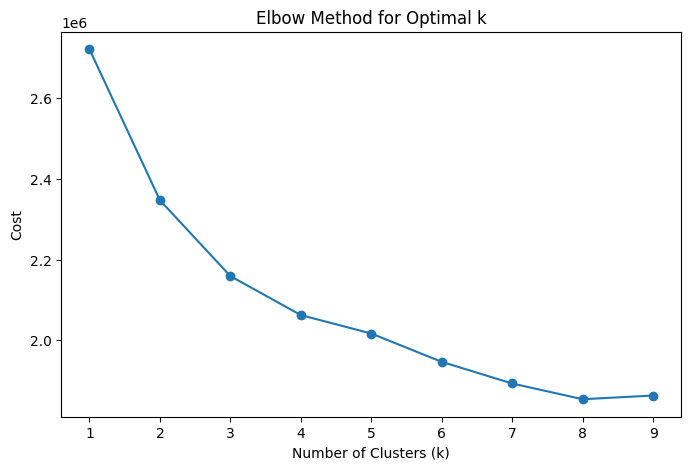

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [50]:
# pd.Series(all_results[4]['labels']).value_counts()
pd.Series(optimal_result['labels']).value_counts()

0    82046
2    54743
4    41714
1    32659
3    32481
6    30481
5    24949
7    19333
Name: count, dtype: int64

In [90]:
rbind_data['Cluster'] = optimal_result['labels']
rbind_data.head()

,天候名稱,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,路面狀況-路面鋪裝名稱,路面狀況-路面狀態名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,...,事故類型及型態大類別名稱,肇因研判大類別名稱-主要,當事者區分-類別-大類別名稱-車種,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-最初,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,死亡,受傷,Cluster
0,晴,有照明未開啟或故障,省道,41-50,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車輛本身,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者,1,0,0
1,晴,無照明,市區道路,31-40,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車與車,駕駛者,大客車,車的狀態,汽車,未紀錄,駕駛者,1,1,5
2,陰,有照明且開啟,縣道,51-60,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車輛本身,駕駛者,機車,不明,機車與自行車,未紀錄,駕駛者,1,0,0
3,晴,有照明且開啟,市區道路,31-40,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車與車,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者,1,1,3
4,陰,無照明,省道,51-60,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車輛本身,駕駛者,機車,車的狀態,機車與自行車,機車與自行車,駕駛者,1,0,0


In [57]:
clusters = {}
for cluster_id in sorted(rbind_data['Cluster'].unique()):
    clusters[cluster_id] = rbind_data[rbind_data['Cluster'] == cluster_id]

for cluster_id, cluster_data in clusters.items():
    file_path = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_{cluster_id}.csv"
    cluster_data.to_csv(file_path, index=False)
    print(f"群體 {cluster_id} 的資料已保存到 {file_path}")

群體 0 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_0.csv
群體 1 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_1.csv
群體 2 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_2.csv
群體 3 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_3.csv
群體 4 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_4.csv
群體 5 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_5.csv
群體 6 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_6.csv
群體 7 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_7.csv


In [58]:
c0 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_0.csv", low_memory=False)
c1 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_1.csv", low_memory=False)
c2 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_2.csv", low_memory=False)
c3 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_3.csv", low_memory=False)
c4 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_4.csv", low_memory=False)
c5 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_5.csv", low_memory=False)
c6 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_6.csv", low_memory=False)
c7 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/cluster_7.csv", low_memory=False)

In [82]:
for i in range(8):
    C_n = rbind_data[rbind_data['Cluster']==i]
    print(C_n['當事者區分-類別-大類別名稱-車種'].value_counts())

當事者區分-類別-大類別名稱-車種
機車             73961
慢車              4923
人               1312
未紀錄              865
小客車(含客、貨兩用)      368
小貨車              190
小貨車(含客、貨兩用)      168
大客車               87
其他車               84
大貨車               60
曳引車               15
特種車                6
半聯結車               6
全聯結車               1
Name: count, dtype: int64
當事者區分-類別-大類別名稱-車種
小客車(含客、貨兩用)    24995
小貨車             1415
機車              1380
小貨車(含客、貨兩用)     1165
大客車              771
大貨車              672
未紀錄              652
慢車               515
人                468
曳引車              256
半聯結車             222
其他車               66
全聯結車              38
特種車               36
軍車                 8
Name: count, dtype: int64
當事者區分-類別-大類別名稱-車種
機車             46861
慢車              3667
小客車(含客、貨兩用)     2704
未紀錄              521
人                448
小貨車              236
小貨車(含客、貨兩用)      182
其他車               48
大貨車               38
大客車               23
曳引車                8
特種車                3
半聯結車               2
全聯結車        

In [66]:
result = compare_categorical_features(c0.drop(['Cluster'], axis=1), 
                                      c1.drop(['Cluster'], axis=1))
result.sort_values(by="chi2", ascending=False)

,chi2,p_value
當事者區分-類別-大類別名稱-車種,97956.004014,0.000000e+00
車輛撞擊部位大類別名稱-最初,93184.615514,0.000000e+00
保護裝備名稱,83367.370648,0.000000e+00
車道劃分設施-分道設施-快車道或一般車道間名稱,25137.078981,0.000000e+00
車道劃分設施-分向設施大類別名稱,15432.949781,0.000000e+00
速限-第1當事者,11022.712023,0.000000e+00
車輛撞擊部位大類別名稱-其他,10091.348082,0.000000e+00
當事者事故發生時年齡,9161.680976,0.000000e+00
道路類別-第1當事者-名稱,7003.686702,0.000000e+00
受傷,3278.512185,0.000000e+00


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = dummy_data
y = optimal_result['labels']

X_train, X_test, y_train, y_test = train_test_split(dummy_data, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 特征重要性排序
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

In [92]:
feature_importances

,Feature,Importance
160,車輛撞擊部位大類別名稱-最初_汽車,4.888761e-02
118,事故位置大類別名稱_路段,4.417700e-02
110,道路型態大類別名稱_交岔路,4.399802e-02
61,號誌-號誌種類名稱_無號誌,4.194345e-02
69,車道劃分設施-分道設施-快車道或一般車道間名稱_未繪設車道線,4.184238e-02
...,...,...
152,當事者區分-類別-大類別名稱-車種_軍車,2.016037e-06
8,天候名稱_風沙,1.529425e-06
125,事故類型及型態大類別名稱_平交道事故,5.622591e-07
82,當事者屬-性-別名稱_無人駕駛自動車,1.088187e-07


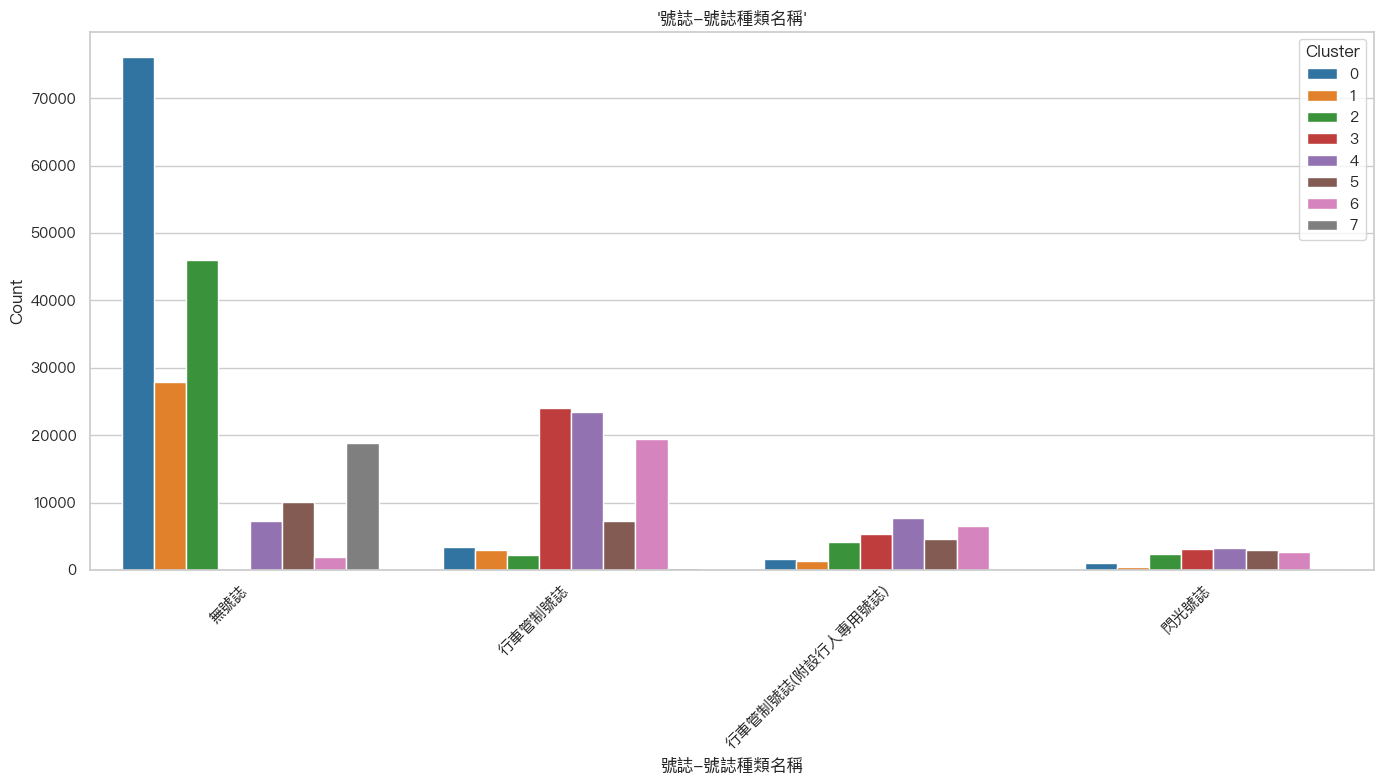

In [96]:
import seaborn as sns
from matplotlib.font_manager import FontProperties

attr = '號誌-號誌種類名稱'

myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
sns.set(style="whitegrid", font=myfont.get_name())

plt.figure(figsize=(14, 8))
sns.countplot(
    data=rbind_data,
    x=attr,
    hue='Cluster',  # 按 Cluster 分组显示
    order=rbind_data[attr].value_counts().index,  # 按频率排序
    palette="tab10"
)
plt.title(f"'{attr}'")
plt.xlabel(f"{attr}")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()